# Ribosome Stalling Sites

First, create the infrastructre for the analysis.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

temp_repo_dir = "/home/kai/KEMALINECIK/from_raf_computer/Kemal/Temp/human"
data_repo_dir = "/home/kai/KEMALINECIK/from_raf_computer/Kemal/Data/sam_bukau"
script_path_infrastructure = "/home/kai/KEMALINECIK/from_raf_computer/Kemal/RiboSeqAnalysis/infrastructure"

spt = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_TT1.sam", "Sixtymers_TT2.sam"]]
sps = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_Rep1.sam", "Sixtymers_Rep2.sam", "Sixtymers_NoPK.sam"]]

erb_serb = [os.path.join(data_repo_dir, f"SeRP/EBP1/Rep{i+1}/IP/IP{i+1}.sam") for i in range(2)]
erb_total = [os.path.join(data_repo_dir, f"SeRP/EBP1/Rep{i+1}/Total/Total{i+1}.sam") for i in range(2)]
nac_serb = [os.path.join(data_repo_dir, f"SeRP/NAC/Rep{i+1}/IP/IP{i+1}.sam") for i in range(2)]
nac_total = [os.path.join(data_repo_dir, f"SeRP/NAC/Rep{i+1}/Total/Total{i+1}.sam") for i in range(2)]

coco_d = [os.path.join(data_repo_dir, i) for i in ["Coco_Dis1.sam", "Coco_Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, i) for i in ["Coco_Mono1.sam", "Coco_Mono2.sam"]]

exclude_genes = ["ENSG00000160789"]

I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  ensembl_release=102,
                  organism="homo_sapiens",
                  verbose=True)

I.riboseq_sixtymers = RiboSeqSixtymers(I.temp_repo_dir, spt, sps, "sixtymers",
                                        riboseq_assign_to="best_transcript", riboseq_assign_at="auto",
                                        protein_genome_instance=I.protein_genome,
                                        gene_info_dictionary=I.gene_info,
                                        exclude_genes=I.exclude_genes, verbose=I.verbose)

## Distribution of RPKM values in imported data

Let's check the relationship between two riboseq data, ideally control vs experiment pairs like sixtymers versus translatome.
<br>
Note: To draw loglog plot, zero values were removed.

In [3]:
import statsmodels.api as sm
from scipy import stats 
import seaborn as sns
from matplotlib import gridspec

In [4]:
def compare_two_riboseq(arr1, arr2, narr1, narr2, general=None): # translatome, sixtymers:
    # Plot the result as histograms
    fig = plt.figure(figsize=(12, 5)) 
    if general: fig.suptitle(general, y=1.05, fontweight="bold")
    gs = fig.add_gridspec(1, 2, width_ratios=[1.25, 1])
    axes0 = plt.subplot(gs[0])
    axes0.set_yscale('log')
    axes0.set_ylabel('Gene count')
    axes0.set_xlabel(f'RPKM')
    values = np.concatenate([arr1,arr2])
    labels = np.array([narr1] * len(arr1) + [narr2] * len(arr2))
    df_temp = pd.DataFrame.from_dict(dict(zip(["RPKM", "Label"], [values, labels])))
    sns.histplot(df_temp, x="RPKM", hue="Label", multiple="dodge", ax=axes0, bins=30)
    
    # Fit the linear line to the loglog
    non_zero = np.intersect1d(np.nonzero(arr1), np.nonzero(arr2))
    arr1_log = np.log10(arr1[non_zero])
    arr2_log = np.log10(arr2[non_zero])
    results = sm.OLS(arr2_log, sm.add_constant(arr1_log)).fit()
    x_data_log = np.linspace(arr1_log.min(), arr1_log.max(), 1000)
    y_data_log = x_data_log * results.params[1] + results.params[0]

    # Plot the result
    axes1 = plt.subplot(gs[1])
    axes1.set_xlabel(f"{narr1} RPKM (x)")
    axes1.set_ylabel(f"{narr2} RPKM (y)")
    axes1.set_xscale('log')
    axes1.set_yscale('log')
    axes1.scatter(x=arr1[non_zero], y=arr2[non_zero], marker='.', edgecolors='none')
    axes1.plot(10**x_data_log, 10**y_data_log, color="black")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    textstr = '\n'.join((
        r'$log_{10}(y)=log_{10}(x)*%.2f + %.2f$' % (results.params[1], results.params[0]),
        r'$y=x^{%.2f}*10^{%.2f}$' % (results.params[1], results.params[0]),
        r'$R^2=%.2f$' % (results.rsquared,),
        ))
    axes1.text(0.025, 0.975, textstr, transform=axes1.transAxes, verticalalignment='top', horizontalalignment="left", bbox=props, alpha=1)
    plt.tight_layout()
    plt.show()
    
    # Check the correlation between RPKM values of translatome and experiment for sixytmer data
    corr_nonzero = stats.pearsonr(tt_rpkms[non_zero], ex_rpkms[non_zero])
    corr_all = stats.pearsonr(tt_rpkms, ex_rpkms)
    print("Pearson correlation (only nonzero): %.4f, where p=%.2f" % (corr_nonzero[0], corr_nonzero[1]))
    print("Pearson correlation (all): %.4f, where p=%.2f" % (corr_all[0], corr_all[1]))

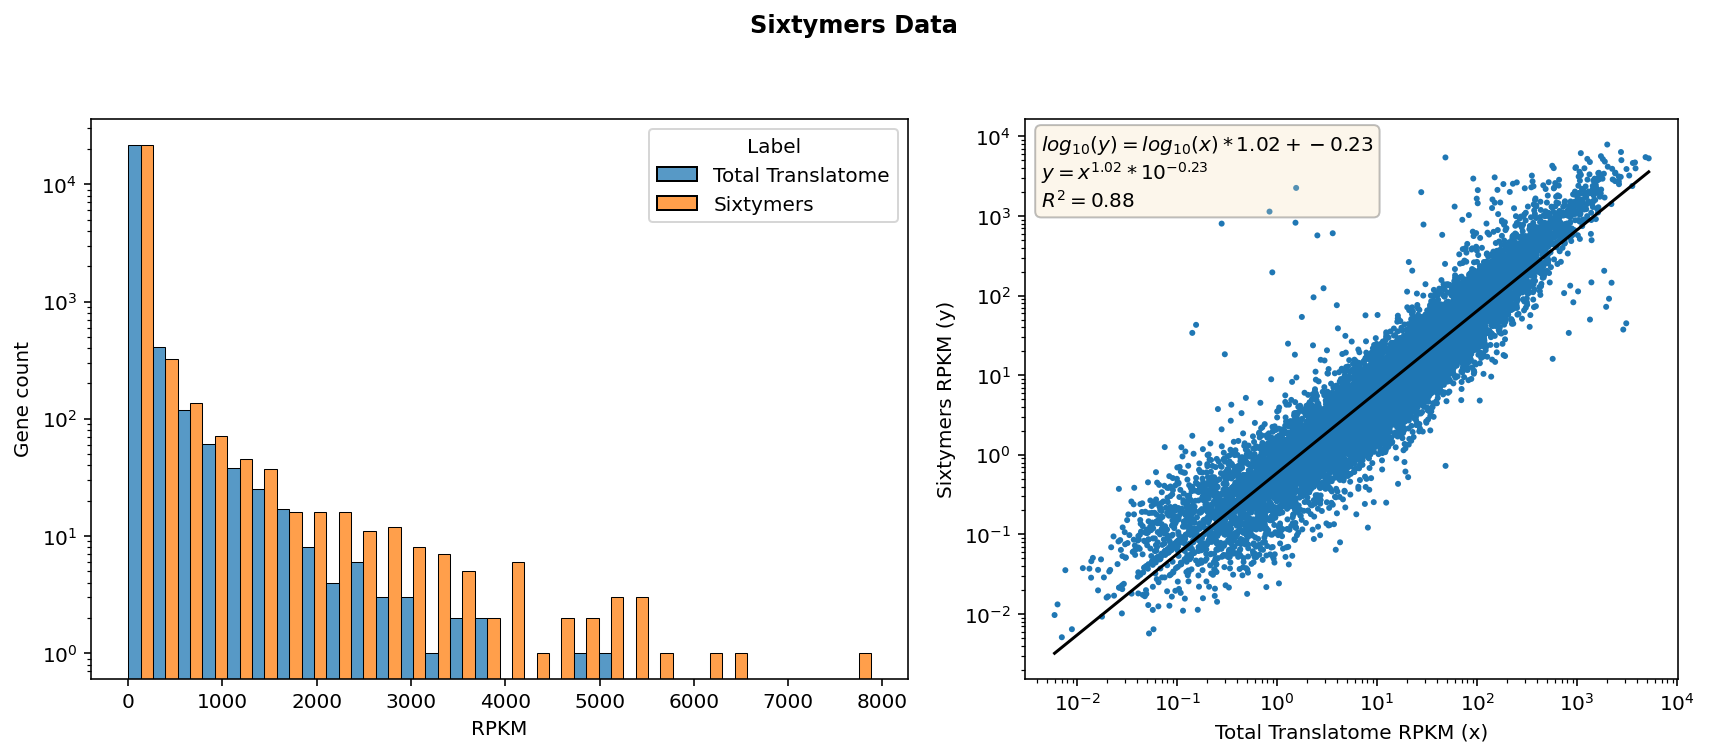

Pearson correlation (only nonzero): 0.7959, where p=0.00
Pearson correlation (all): 0.8010, where p=0.00


In [5]:
# Get the total translatome and experiment RPKM values for sixytmer data.
tt_rpkms = np.array([I.riboseq_sixtymers.background.calculate_rpkm_genes(g) for g in I.gene_list])
ex_rpkms = np.array([I.riboseq_sixtymers.experiment.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_rpkms, ex_rpkms, "Total Translatome", "Sixtymers", "Sixtymers Data")

## Amino Acid Windows

In [46]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
probabilities = (0.120, 0.100, 0.080, 0.060, 0.040, 0.020, 0.010, 0.005)

# Methods
inecik5 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_5, min_rpkm_sixtymers=-1, min_rpkm_background=1)
arpat = partial(I.riboseq_sixtymers.stalling_peaks_arpat, mmc_threshold=1, normalized_peak_count_thr=5, get_top=5)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_inecik5_protein_sequences.joblib")
try:  # Because it takes very long, as written very inefficiently.
    raise FileNotFoundError
    W = joblib.load(save_metadata_path)
except FileNotFoundError:

    ci = [[] for _ in range(len(probabilities))]
    windows = [ci, [], []]  # inecik5, arpat, monte_carlo
    peak_counts = [0] * len(probabilities)
    
    for ind, gene_id in enumerate(I.gene_list):
        progress_bar(ind, len(I.gene_list) - 1, verbose=True)
        best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
        protein_sequence = I.protein_genome.db[best_transcript][1]
        length_protein = len(protein_sequence)
        assert "." not in protein_sequence
        protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
        # My methods
        for param1 in range(len(probabilities)):
            peaks3 = (np.floor(inecik5(gene_id, probability=probabilities[param1]) / 3) + window_flank).astype(int)
            peak_counts[param1] += len(peaks3)
            for peak in peaks3:
                windows[0][param1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Arpat
        peaks5 = (np.floor(arpat(gene_id) / 3) + window_flank).astype(int)
        for peak in peaks5:
            windows[-2].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Monte Carlo
        peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
        for peak in peaks_mc:
            windows[-1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])        

    ci = [None for _ in range(len(probabilities))]
    W = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), None, None]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo


    for param1 in range(len(probabilities)):
        W_temp = np.chararray((len(windows[0][param1]), window_len), itemsize=1)
        W_temp[:] = "."
        for ind, peak_window in enumerate(windows[0][param1]):
            W_temp[ind] = list(peak_window)
        W[0][param1] = W_temp

    for other_method in range(-2,0,1):
        W_temp = np.chararray((len(windows[other_method]), window_len), itemsize=1)
        W_temp[:] = "."
        for ind, peak_window in enumerate(windows[other_method]):
            W_temp[ind] = list(peak_window)
        W[other_method] = W_temp

    del windows
    joblib.dump(W, save_metadata_path)

Progress: |████████████████████| 100.0% 


## Charge

In [47]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
charges = list()
for k in range(1):
    charges_method = list()
    for i in range(len(probabilities)):
        charges_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
            charges_temp.append(average_charge)
        charges_method.append(charges_temp)
    charges.append(charges_method)
# Arpat & Monte Carlo
for k in range(-2,0,1):
    charges_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
        charges_temp.append(average_charge)
    charges.append(charges_temp)

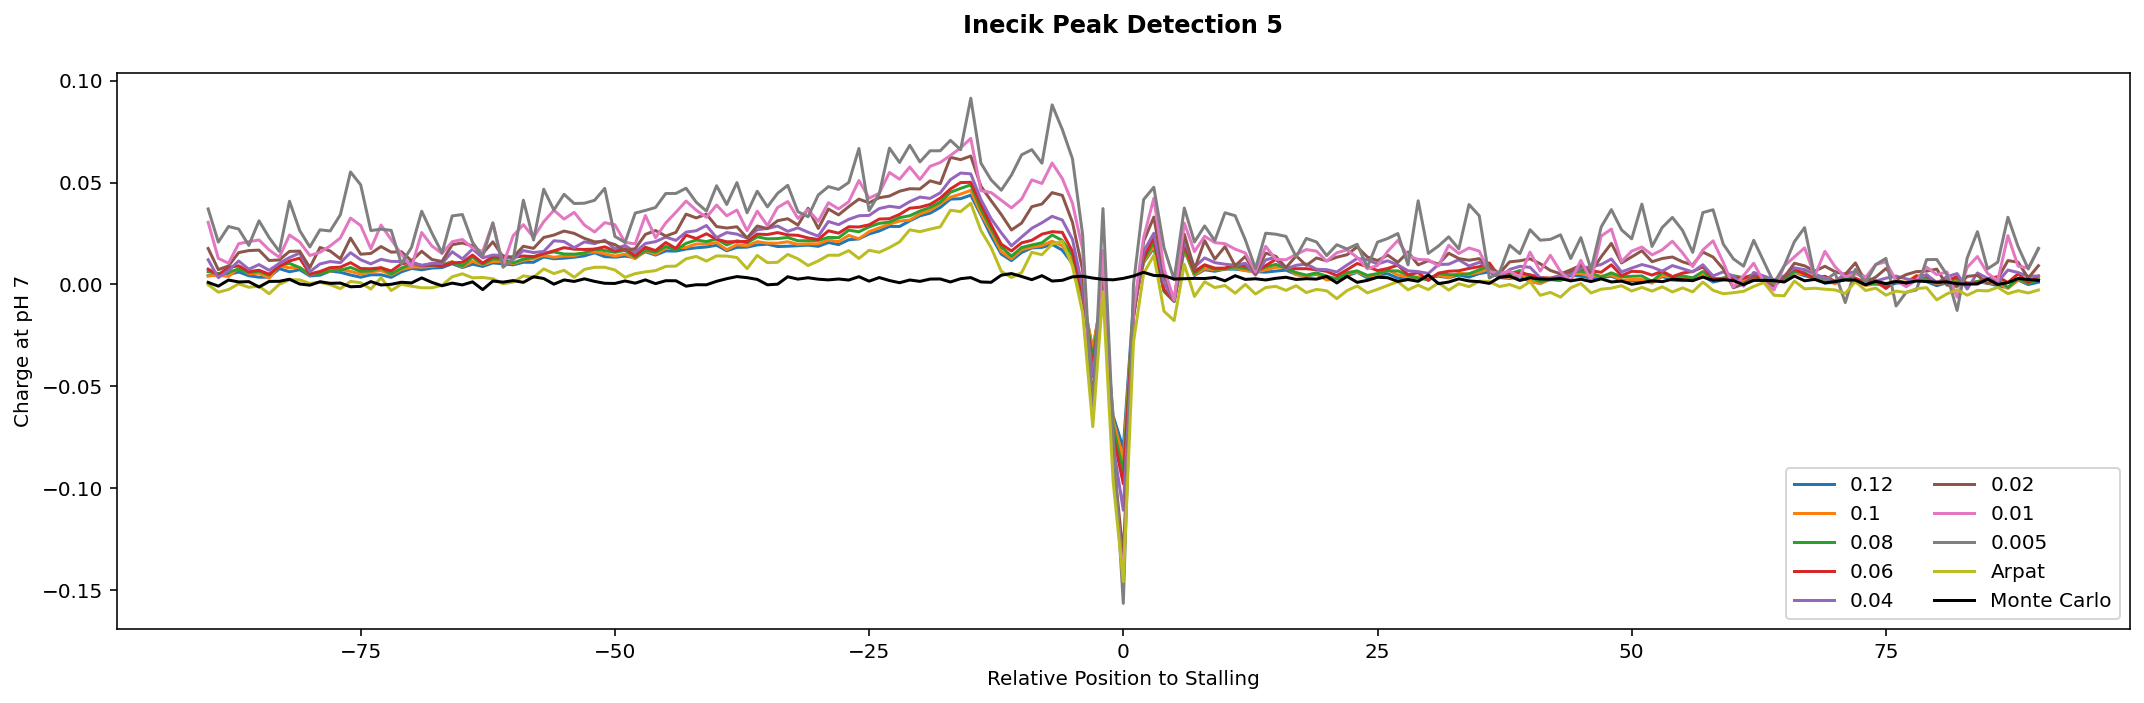

In [48]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(probabilities)):
    plt.plot(x, charges[m][i], label=probabilities[i] if m!=2 else probabilities[i])
plt.plot(x, charges[-2], label="Arpat")
plt.plot(x, charges[-1], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection 5", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Charge at pH 7")
plt.tight_layout()
#plt.savefig("Charge_window.pdf")
plt.show()

## Aminoacid Residues

In [49]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def aa_probs(mm="P"):
    # Inecik Methods
    proline = list()
    for k in range(1):
        proline_method = list()
        for i in range(len(probabilities)):
            proline_temp = list()
            W_temp = W[k][i].T
            for j in range(window_len):    
                aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
                pa = ProteinAnalysis(aminoacids_vertical)
                average_proline = pa.get_amino_acids_percent()[mm]
                proline_temp.append(average_proline)
            proline_method.append(proline_temp)
        proline.append(proline_method)
    # Arpat & Monte Carlo
    for k in range(-2,0,1):
        proline_temp = list()
        W_temp = W[k].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_proline = pa.get_amino_acids_percent()[mm]
            proline_temp.append(average_proline)
        proline.append(proline_temp)
    return proline
    
aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_amino_acid_probabilities.joblib")
try:  # Because it takes very long, as written very inefficiently.
    aad = joblib.load(save_metadata_path)
except FileNotFoundError:
    executor = multiprocessing.Pool(len(aa))
    result = executor.map(aa_probs, aa)
    executor.terminate()
    executor.join()
    aad = dict(zip(aa, result))
    joblib.dump(aad, save_metadata_path);

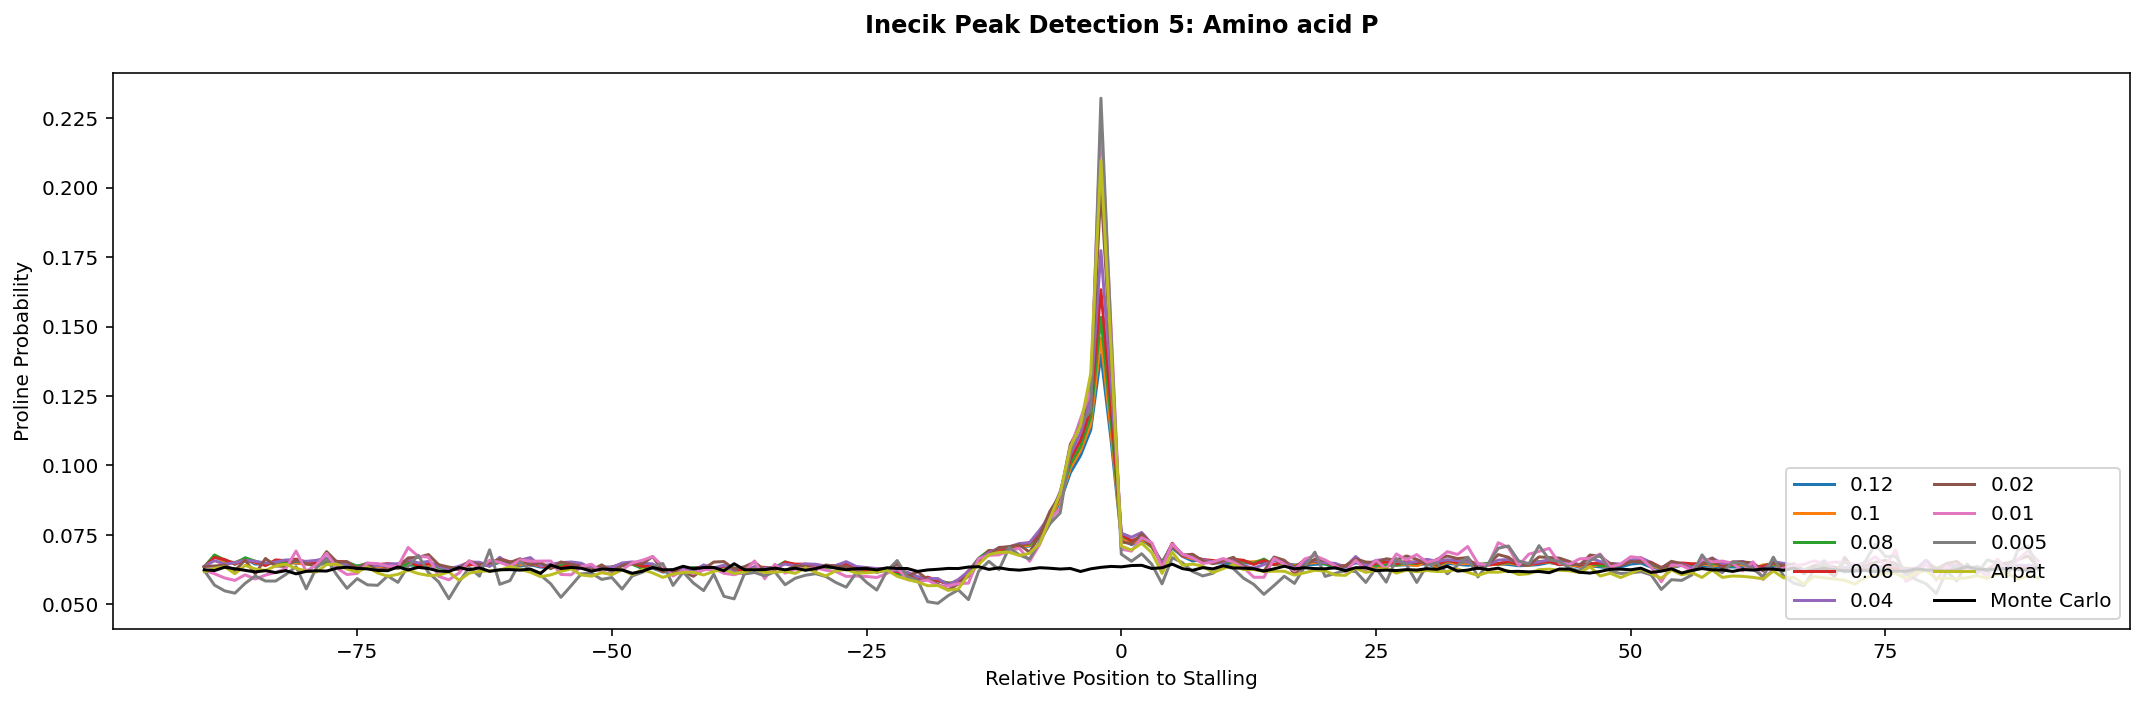

In [50]:
mm = "P"
m = 0
fig = plt.figure(figsize=(15,5))
x = np.arange(-window_flank, window_flank + 1)
for i in range(len(probabilities)):
    plt.plot(x, aad[mm][m][i], label=probabilities[i] if m!=2 else probabilities[i])
plt.plot(x, aad[mm][-2], label="Arpat")
plt.plot(x, aad[mm][-1], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection 5: Amino acid {mm}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Proline Probability")
plt.tight_layout()
#plt.savefig("Proline_window.pdf")
plt.show()

In [51]:
# More accurate objective function

# https://en.wikipedia.org/wiki/Position_weight_matrix
def information_content(aad, inecik_method, perc):  # Relative entropy
    ic = 0
    for mm in aa:  
        observed = np.array(aad[mm][inecik_method][perc])
        expected = np.array(aad[mm][-1])
        ic += - np.log(expected/observed) * observed
    return ic

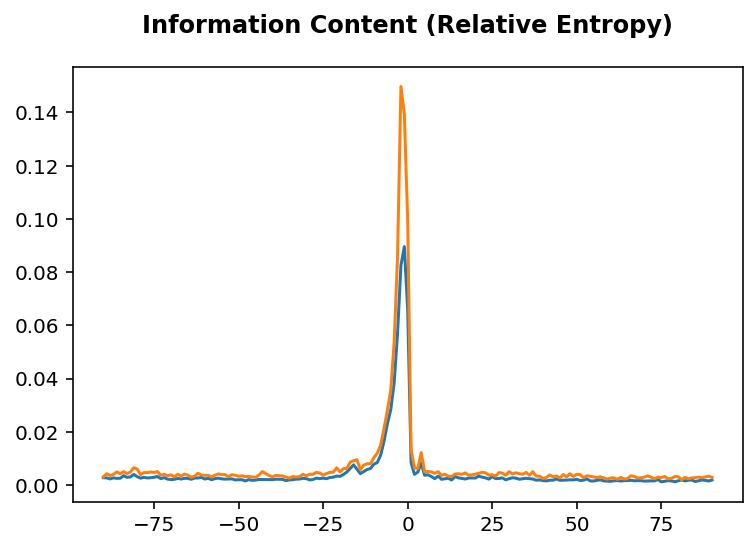

In [52]:
plt.plot(x, information_content(aad, 0, 2))
plt.plot(x, information_content(aad, 0, 5))
plt.title("Information Content (Relative Entropy)", y=1.05, fontweight="bold")
#plt.savefig("information_content.pdf")
plt.show()

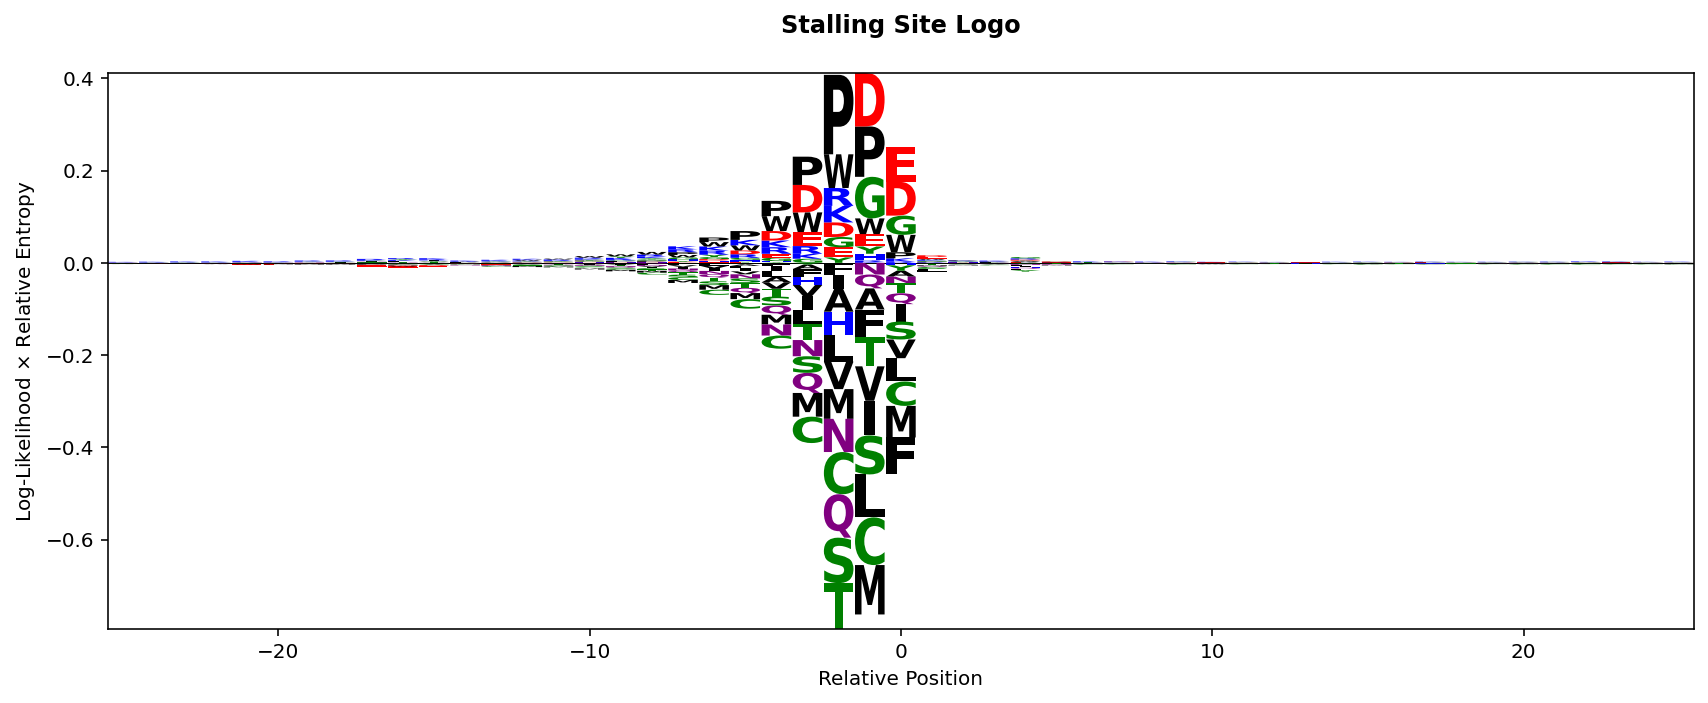

In [53]:
import logomaker
mmaa = list()
method_number = 0
ic = information_content(aad, method_number, probabilities.index(0.02))
for mm in aa:
    observed = np.array(aad[mm][method_number][probabilities.index(0.02)])
    expected = np.array(aad[mm][-1])
    position_weight_matrix = ic * np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-25: 25]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.savefig("Logo_info_2ll.pdf")
plt.show()

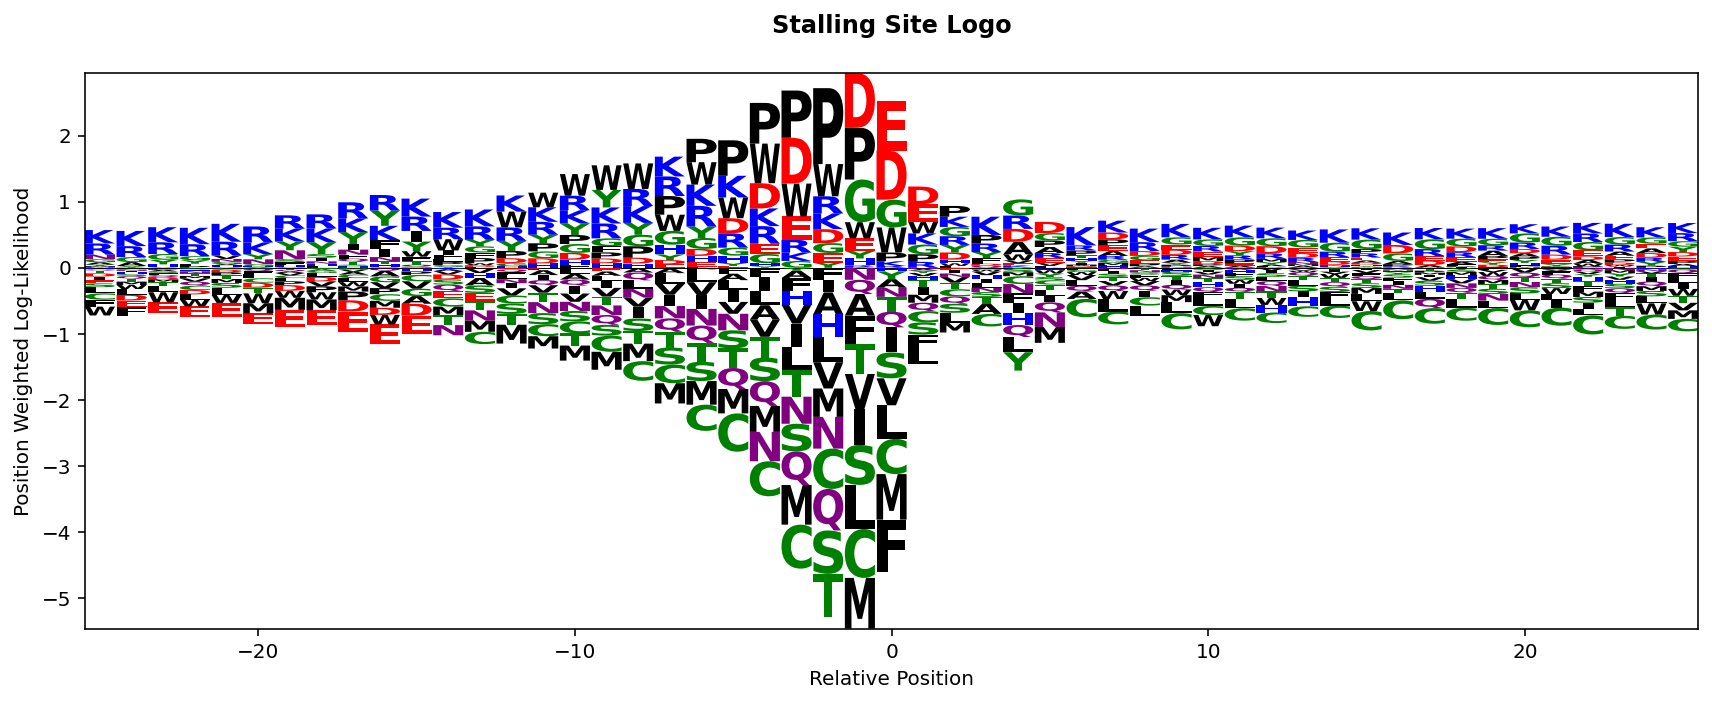

In [54]:
mmaa = list()
for mm in aa:
    observed = np.array(aad[mm][method_number][probabilities.index(0.02)])
    expected = np.array(aad[mm][-1])
    position_weight_matrix = np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-25: 25]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Position Weighted Log-Likelihood")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.savefig("Logo_2ll.pdf")
plt.show()